# Section 9 - Statistical Assessment for Big Data

What happens if we move to real world, i.e. large datasets and unsure about specific hypothesis to test.

In [1]:
library(data.table)
library(ggplot2)
library(tidyr)
library(magrittr)
library(gridExtra)
library(ggbeeswarm)

options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 100)

file_path <- file.path("/Users", "donatabuozyte", "Downloads", "extdata")


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
# --------------------

## Motivation: Statistical Significance in a Big Data Context

Case: scientists gather variety of demographic, social, health data of Germans.

Report: statistically significant association, i.e. *P* < 0.05, between drinking cofee and all-cause mortality in university students aged 19-25 with bithdays at odd-numbered months.

Problem: report without further information not convincing.

---

Major issues:
1. small effect detection size (consequence of large sample sizes, i.e. many rows)
2. issue of multiple testing (consequence of assessing many variables, i.e. many columns)

In [3]:
# --------------------

## Effect Size: Actually Important or Just Significant?

First problem: statistical significance does not necessarily reflect effects of prectical relevance.

---

**Effect size**:
- quantitative measure of magnitude of phenomenon.
- determines wether effect actually important. (e.g. effects of drinking more than 20 cups of coffee is rather unimportant)

Examples: correlation between two variables, the regression coefficient in a regression, the mean difference, risk with which something happens

### 1. Relationship of Sample Size and Significance

Assumption: small effect size.

Example: two groups $X, Y$, normally distributed with variance 1, but $\mu_{X} = 0$ and $\mu_{Y} = 0.01$

Null hypothesis:  $\mu_{X} = \mu_{Y}$ (test via t-test).

---

Obervation: increasing sample size leads to rapidly decreasing P-value. Hence null hypothesis is rejected at as certain amount of samples.

Conclusion: growing sample size reveals true effect (no matter how small).

---

Problem: effect size rarely exactly 0 in real world, hence likely to find only significant associations.

[1] 0.07979818

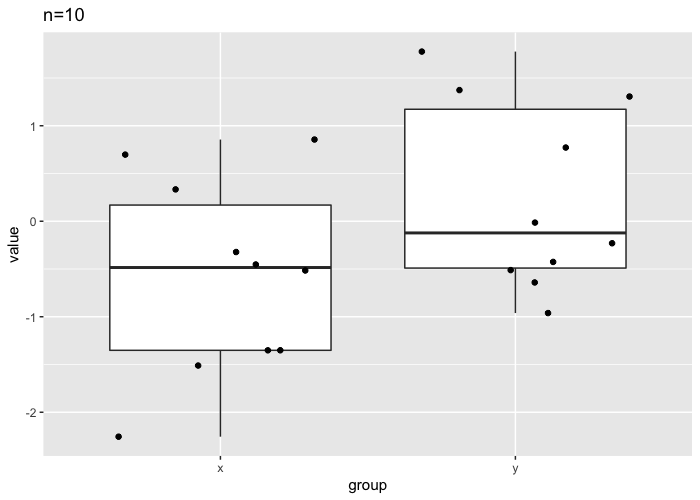

In [4]:
# example with small sample size (10)

mu_x  <- 0
mu_y  <- 0.01
n <- 10
x <- rnorm(n, mu_x)
y <- rnorm(n, mu_y)

dt <- data.table(
  value = c(x,y),
  group =rep(c("x", "y"), each=n)
)

t.test(x,y)$p.value
ggplot(dt, aes(x=group, y=value)) + 
  geom_boxplot() +
  geom_jitter() +
  ggtitle(paste0("n=",n))

[1] 0.8983356

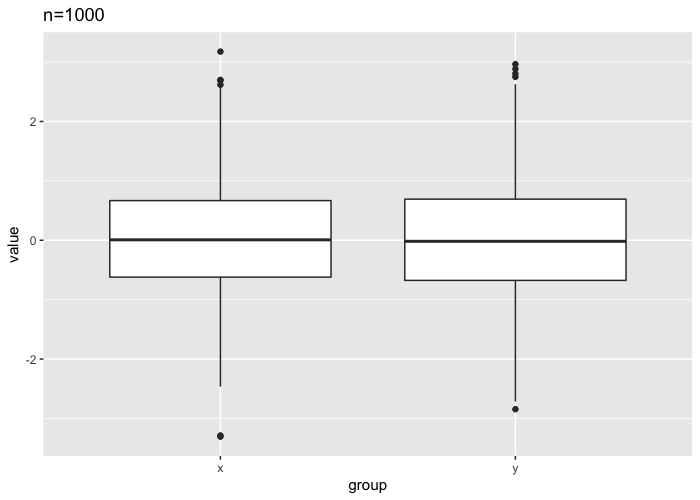

In [5]:
# for more data points: a bit more stable, but still no significant P-value
n <- 1000
x <- rnorm(n, mu_x)
y <- rnorm(n, mu_y)

dt <- data.table(
  value = c(x,y),
  group =rep(c("x", "y"), each=n)
)

t.test(x,y)$p.value
ggplot(dt, aes(x=group, y=value)) + 
  geom_boxplot() +
  # geom_jitter() +
  ggtitle(paste0("n=",n))

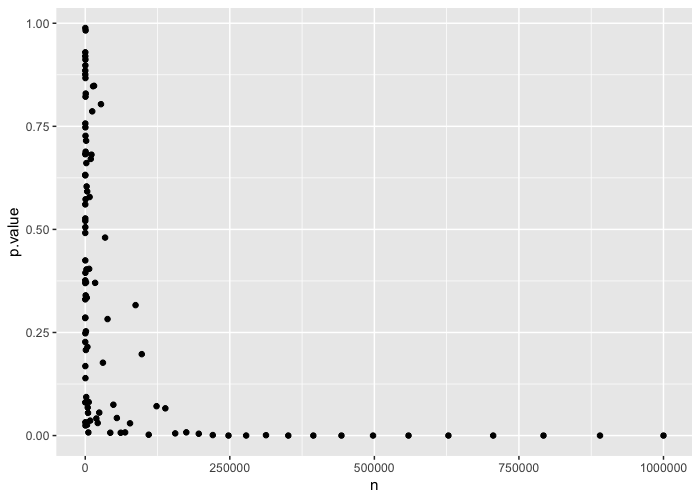

In [6]:
# significantly higher sample size

ns <- round(10^seq(1,6, length.out=100))     # a exponential grid of values of n 
pvs <- sapply(ns,                            # for each N... 
  function(n){
    x <- rnorm(n, mu_x)                      # draw N values of x according to N(mu_x, 1) 
    y <- rnorm(n, mu_y)                      # draw N values of y according to N(mu_y, 1) 
    t.test(x, y)$p.value                     # Welch t-test 
  }
)
data.table(n=ns, p.value=pvs) %>% ggplot(aes(x=n , y=p.value)) +
                                    geom_point()

### 2. Report P-value, Effect Dize and Plot

Therefore: only reporting "association is statistically significant" misleading.

Report: P-value, estimate of effect, plot data supporting conclusion.

In [7]:
# --------------------

## Multiple Testing

Second problem: detect false effects due to multiple testing.

### 1. Multiple Testing in Real Life: P-Hacking and Fishing Expeditions

“P-hacking” or fishing expedition: practice of testing different hypotheses until until one yield significant P-value.

Issue: test enough hypotheses at given significance level, then we are bound to eventually get significant result, even if null hypothesis always true. Often appears when large datasets stratisfied into subgroups and seperate hypothesis tested for each.

Example: test effect of medication with no effect in general population and test it for certain subgroups, like women, men, smokers. Then bound to find one where P-value below significance level even if medication useless.

Conclusion: if data starisfied, then apply correction accounting for the performed multiple tests.

### 2. Land of Counterfeit (Fake) Coins *(used in following subsections)*

Concrete example of multiple testing and a correction:
- assumption: counterfeit coins (unfair coins when tossed, biased towards head) circulating
- method: 1000 people should toss their coin 20 times

### 3. Simulation

Based on example above: in reality, 90% of the people have fair coins.

For simplicity: counterfeits have probability of 80% for head.

In [8]:
set.seed(10)
m <- 1e3 
m0 <- 0.9*m 
n <- 20 
fair <- c(rep("fair", m0), rep("biased", m-m0)) 
heads <- rbinom(m,n,ifelse(fair=="fair",0.5,0.8)) 

dt <- data.table(fair=fair, heads=heads)
dt %>% head()
dt %>% tail()

fair,heads
fair,10
fair,9
fair,10
fair,11
fair,7
fair,8


fair,heads
biased,17
biased,15
biased,18
biased,16
biased,18
biased,12


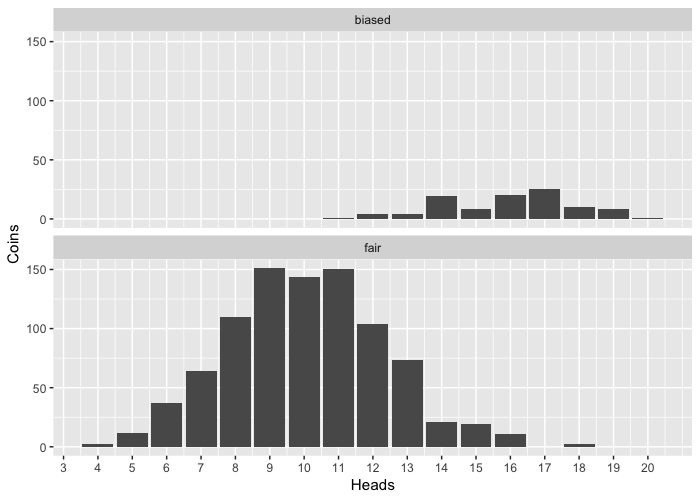

In [9]:
# distribution of heads
dt2 <- dt[, .N, by=.(fair,heads)]
dt2 %>% ggplot(aes(heads,N)) + 
          geom_bar(stat="identity")  + 
          facet_wrap(~ fair, nrow=2) +
          scale_x_continuous("Heads", 0:n) +
          scale_y_continuous("Coins")

### 4. Nominal P-Values

Null hypothesis: each coin is fair.

Reject null hypothesis if hypothesis using one-sided binomial test at P-value <= 0.05.

---

After testing: 104 coins counterfeit?

In [10]:
# compute P-values
dt[,
   p.value := sapply(
     heads,
     function(x)
       binom.test(x, n = n, alternative = "greater")$p.value
     )
]

dt %>% head()
dt %>% tail()

# number of rejected tests
sum(dt$p.value<=0.05)

fair,heads,p.value
fair,10,0.5880985
fair,9,0.7482777
fair,10,0.5880985
fair,11,0.4119015
fair,7,0.9423409
fair,8,0.8684120


fair,heads,p.value
biased,17,0.0012884140
biased,15,0.0206947327
biased,18,0.0002012253
biased,16,0.0059089661
biased,18,0.0002012253
biased,12,0.2517223358


[1] 104

#### 4.1 Explanation: Nominal  P-Values can lead to many false rejections when testing multiple hypotheses

Contingency table shows: 32 innocent people accused despite rigorous statistical testing against null hypothesis of innocenc to establish guilt.

---

**What went wrong?**:

1. under null hypothesis: $p(P<\alpha | H_{0}) = \alpha$.
2. definition of P-value: probability of obtaining test statistic same as or more extreme than one we actually observed, under the assumption that null hypothesis true.
3. right-tailed one-sided test: $P=p(T \geq T_{\mathrm{obs}} | H_{0})$

Now let $T_{0.05}$ be s.t. $0.05=p(T \geq T_{0.05} | H_{0})$. Then probability under hull hypothesis that $P<0.05$ is $p(T \geq T_{0.05} | H_{0}) = 0.05$. (Logic also works for other values.)

Conclusion: test 900 coins, reject that coin is fair when $P<0.05$. Then null hypothesis rejected 5% of the time, i.e. 45 times.

---

Other formulation: under null hypothesis, P-value follows uniform distribution on [0,1], see plot.

P-values for fair coins math uniform distribution quiet well, while P-values for biased coins excessively small compared to uniform distribution

In [11]:
# contingency table
table(dt[,.(fair, rejected = p.value<=0.05)])

        rejected
fair     FALSE TRUE
  biased    28   72
  fair     868   32

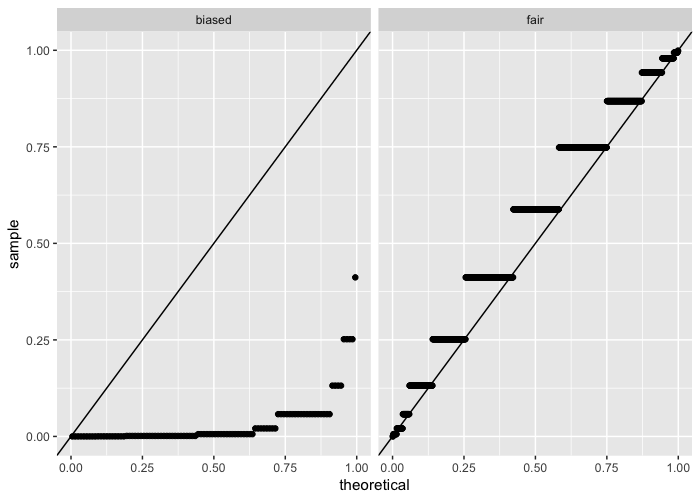

In [12]:
# comparison: P-value distribution and uniform distribution
# stairs only due to ties :)
ggplot(dt, aes(sample = p.value)) +                            
  geom_qq(distribution =  stats::qunif) +     # we make a qqplot comparing the p-values with the [0,1] uniform                           
  geom_abline(slope=1, intercept=0) +         # we add a diagonal                               
  facet_wrap(~fair)                           # we make the plot separately for fair and biased coins

### 5. Family-Wise Error Rate

Statement: "if all innocent, then $0.05*1000=50$ falsely declared guilty. not ok.", but how to be 100% sure? 

Compromise: make sure that at most 5% chance that innocent person is accused.

---

Bonferroni correction: multiply P-values by $m=1000$ or setting them to 1, whichever is smaller (as probability never larger then 1).

New contingency table: no innocent person accused, but could have happend with less that 5% chance.

In [13]:
dt[ , bonferroni := p.adjust(p.value, method="bonferroni")]

dt %>% head()
dt %>% tail()

fair,heads,p.value,bonferroni
fair,10,0.5880985,1
fair,9,0.7482777,1
fair,10,0.5880985,1
fair,11,0.4119015,1
fair,7,0.9423409,1
fair,8,0.8684120,1


fair,heads,p.value,bonferroni
biased,17,0.0012884140,1.0000000
biased,15,0.0206947327,1.0000000
biased,18,0.0002012253,0.2012253
biased,16,0.0059089661,1.0000000
biased,18,0.0002012253,0.2012253
biased,12,0.2517223358,1.0000000


In [14]:
table(dt[,.(fair, rejected = bonferroni<=0.05)])

        rejected
fair     FALSE TRUE
  biased    91    9
  fair     900    0

#### 5.1 Explanation: Bonferroni Correction is Very Conservative Cethod for Addressing Multiple Testing

$\begin{matrix}
(Notation) & \textbf{Not rejected} & \textbf{Rejected} & \textbf{Total} \\
\textbf{True null hypotheses} & U & V & m_{0} \\
\textbf{False null hypotheses} & T & S & m-m_{0} \\
\textbf{Total} & m-R & R & M \\
\end{matrix}$

Goal: keep *V* as low as possible.

Method: control Family-wise error rate (FWER) $p(V>0)$ (probability of one or more false positives).

---

Keep FWER below certain level $\alpha$: *m* tests under hypothesis and reject if $P<\alpha$, the falsely reject $m\alpha$times.

Control FWER via Bonferroni correction: more demanding and only reject if $P < \frac{\alpha}{m}$.

---

*More formally*:

Conduct *m* hypothesis test for each $g=1, \ldots, m$ producing P-values $P_{g}$. Then Bonferroni-adjusted P-values are $\tilde{P}_{g} = \min\{mP_{g}, 1\}$.

Selecting all tests with $\tilde{P}_{g} \leq \alpha$ controls FWER ar level $\alpha$, i.e. $p(V>0) \leq \alpha$. (proof in lecture notes!)

In R: `p.adjust(p_values, method = "bonferroni")`.

---

Conclusion: if 1000 tests at level 0.05 are tested, the hypothesis will be only rejected if the adjusted P-value is smaller than 0.00005.

### 6. False Discovery Rate

Statement: "if all innocent as asumend, then 50 with P-value less than 0.05 already. But result was 104. Hence still a lot ofcounterfeiters undetected. Introduce milder consequences?"

Compromise: no more than 5% actually innocent.

Conclusion: control proportion of innocent people among all guilty people, i.e. where `rejected` is `True`.

---

False Discovery Rate with Benjamini-Hochberg correction: contr9ol expected value of proportion.

New contingency table: more counterfeits discovered and proportion of false positives below 5% (2 out of 46).

In [15]:
dt[ , BH := p.adjust(p.value, method="BH")]

dt %>% head()
dt %>% tail()

fair,heads,p.value,bonferroni,BH
fair,10,0.5880985,1,0.9424656
fair,9,0.7482777,1,0.9655196
fair,10,0.5880985,1,0.9424656
fair,11,0.4119015,1,0.8581281
fair,7,0.9423409,1,0.9929830
fair,8,0.8684120,1,0.9812565


fair,heads,p.value,bonferroni,BH
biased,17,0.0012884140,1.0000000,0.028009000
biased,15,0.0206947327,1.0000000,0.198987814
biased,18,0.0002012253,0.2012253,0.009582156
biased,16,0.0059089661,1.0000000,0.076739819
biased,18,0.0002012253,0.2012253,0.009582156
biased,12,0.2517223358,1.0000000,0.765113483


In [16]:
table(dt[,.(fair, rejected = BH<=0.05)])

        rejected
fair     FALSE TRUE
  biased    56   44
  fair     898    2

#### 6.1 Explanation: Benjamini-Hochberg Correction Controls False Discovery Rate

Bonferroni correction: conservative view, created worst-case scenario (everyone innocent, then minimize probability of innocents being accused based on this assumption).

Problem: worst case scenario incorrect, see e.g. according Q-Q plot including all people.

In plot: deviation from assumption of uniformity at low end of distribution due to guilty people.

---

Benjamini-Hochberg correction: instead of minimizing probability of false positives, use more balanced view and control False discovery rate (FDR) $\mathrm{FDR} = E[\frac{V}{\max(R,1)}]$, i.e. the expected fraction of false positives among all discoveries. ($\max(R,1)$: ensure non-zero)

Method:
1. order unadjusted P-values. Notation: $P_{j}$ is j-th smallest P-value with the null hypothesis $H_{0,j}$.
2. Control FDR at level $\alpha$: $j^{*} = \max\{j: P_{j} \leq \frac{j \alpha}{m}\}$ and reject $H_{0,j}$ if $j \leq j^{*}$. (proof in lecture notes!)

In R: `p.adjust(p_values, method = "BH")`.

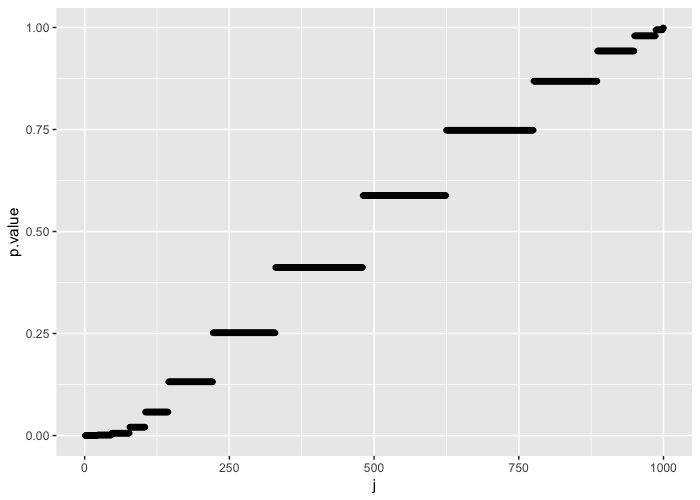

In [17]:
dt_rank <- data.table(p.value = sort(dt$p.value), j = 1:1000)

# Benjamini-Hochberg correction graphically: plot rank of P-values against their actual value
#    (Note: similar to Q-Q plot.)
ggplot(data=dt_rank, aes(x=j,y=p.value)) +
    geom_point()

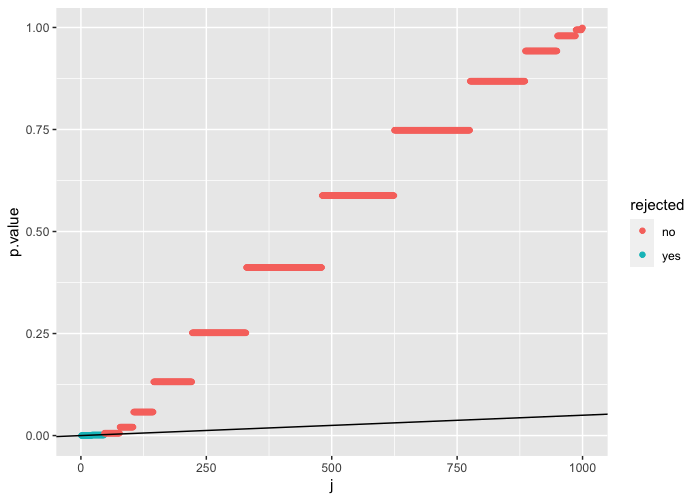

In [18]:
dt_rank[ , BH := p.adjust(p.value, method="BH")]
dt_rank[ , rejected := ifelse(BH<=0.05, "yes", "no")]

# add line with slope alpha/m and find largest P-value below line
# reject this test and all those with smaller P-values
# i.e. reject all tests below this line
ggplot(data=dt_rank) +
    geom_point(aes(x=j,y=p.value,color=rejected)) +   
  geom_abline(aes(intercept=0, slope=0.05/1000))

### 7. Overview Figure

Conclusion: nominal P-value most lenient, (Bonferroni) FWER most stringent, (Benjamini-Hochberg) FDR intermediate.

See lecture notes, section 9.3.7.

In [19]:
# --------------------

## Conlusions

Important: there are reasons to be careful when applying hypothesis testing procedures in big data context, especially as increasing sample size causes that even small effect can become significant, although they might not matter.

Moreover: when running many tests, some are bound to to reject null hypothesis, even though it might be true, Thus corrections need to be applied.

---

Always ask:
1. what was effect size? (if enough of thousand people are sampled, then even small effect detectable)
2. was multiple testing correction applied? (statement might refer to specific subgroups, hence multiple hypotheses tested on group)

##### End of Section 9!